In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/smoking/Training/Training'
test_path = '/kaggle/input/smoking/Testing/Testing'
valid_path = '/kaggle/input/smoking/Validation/Validation'

In [3]:
def extract_from_path(path)-> []:
    full_path = []
    for i in sorted(os.listdir(path)):
        full_path.append(os.path.join(path, i))
    return full_path

In [4]:
train_images = extract_from_path(train_path)
test_images = extract_from_path(test_path)
valid_images = extract_from_path(valid_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of test_images is {len(test_images)}")
print(f"The length of valid_images is {len(valid_images)}")

The length of train_images is 716
The length of test_images is 224
The length of valid_images is 180


In [5]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-1].split('_')[0] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'smoking' else 0)
    return df

In [6]:
train_images_df = createDataFrame(train_images)
test_images_df = createDataFrame(test_images)
valid_images_df = createDataFrame(valid_images)

In [7]:
def plotCount(df):
    name = df["path"][0].split("/")[4]
    smoking = df[df['label_id'] == 1]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total smoking images is {len(smoking)}")
    print(f"Total non-smoking images is {len(df)-len(smoking)}")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)

Total images in Training is 716
Total smoking images is 358
Total non-smoking images is 358


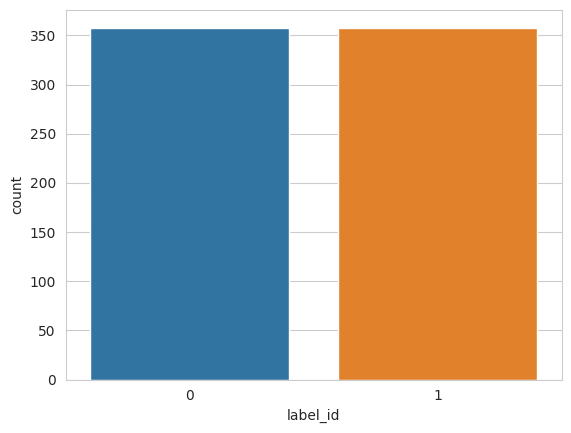

In [8]:
plotCount(train_images_df)

Total images in Testing is 224
Total smoking images is 112
Total non-smoking images is 112


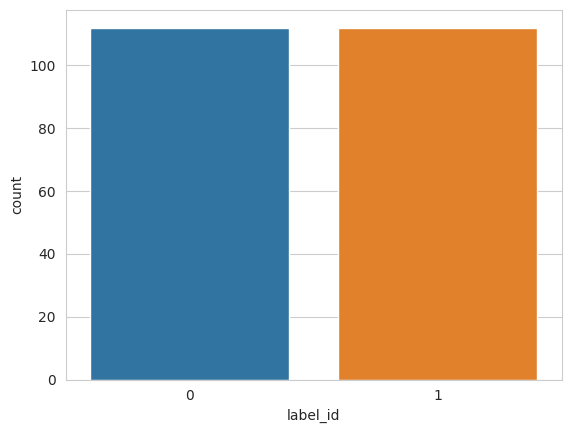

In [9]:
plotCount(test_images_df)

Total images in Validation is 180
Total smoking images is 90
Total non-smoking images is 90


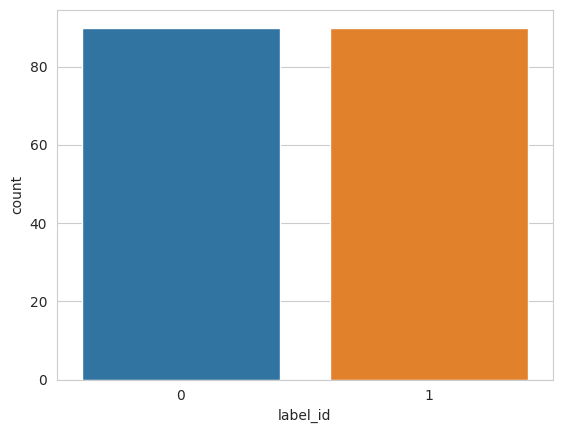

In [10]:
plotCount(valid_images_df)

#### The data set is balanced. It has exactly the same no of images per class in all the three divisions

#### 👨‍🔧  Pre-processing

In [11]:
train_images_df

,path,label,label_id
0,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
1,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
2,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
3,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
4,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
...,...,...,...
711,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
712,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
713,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
714,/kaggle/input/smoking/Training/Training/smokin...,smoking,1


In [12]:
import tensorflow as tf

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

def imgPreProcessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMAGE_SIZE))
    return img, label
def loadDataset(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE))
                

In [13]:
train_data = loadDataset(train_images_df)
test_data = loadDataset(test_images_df)
valid_data = loadDataset(valid_images_df)

In [14]:
# Visualize some random images from the training data

def plotRandom(data):
    for img,label in data.take(1):
        randomNum = random.randint(0, BATCH_SIZE - 1)
        text_label = "Smoking" if label[randomNum].numpy() == 1 else "Non-Smoking"
        plt.figure(figsize=(4, 4))
        plt.imshow(img[randomNum]/255.)
        plt.title(text_label)
        plt.axis('off') 
        plt.show()

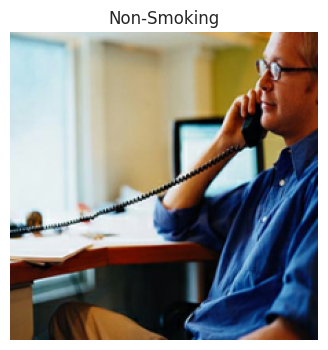

In [15]:
plotRandom(train_data)

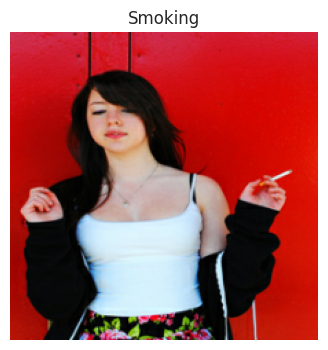

In [16]:
plotRandom(train_data)

##### Fitting a baseline model on the dataset (EfficientNetB0)

In [17]:
def create_b0_base():
    model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    return tf.keras.Model(input_,output)

In [18]:
def plot_history(model_history):
    plt.style.use("seaborn-v0_8-whitegrid")
    df = pd.DataFrame(model_history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    loss = df['loss']
    accuracy = df['accuracy']
    val_loss = df['val_loss']
    val_accuracy = df['val_accuracy']
    epochs = range(len(df['val_loss']))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax2.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title("Loss")
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.set_title("Accuracy")
    
    # Adjust spacing and titles
    plt.tight_layout()
    plt.show()

In [19]:
base_eff0 = create_b0_base()
# compile and fit
base_eff0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
base_eff0_history = base_eff0.fit(train_data,epochs = 5, steps_per_epoch = len(train_data),validation_data = valid_data, validation_steps = len(valid_data))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5


2023-12-18 18:51:33.446357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 21s 227ms/step - loss: 0.5776 - accuracy: 0.7025 - val_loss: 0.3054 - val_accuracy: 0.9056
Epoch 2/5
23/23 [==============================] - 2s 66ms/step - loss: 0.3758 - accuracy: 0.8520 - val_loss: 0.2357 - val_accuracy: 0.9389
Epoch 3/5
23/23 [==============================] - 2s 66ms/step - loss: 0.3193 - accuracy: 0.8883 - val_loss: 0.2074 - val_accuracy: 0.9333
Epoch 4/5
23/23 [==============================] - 2s 67ms/step - loss: 0.2863 - accuracy: 0.8966 - val_loss: 0.1868 - val_accuracy: 0.9278
Epoch 5/5
23/23 [==============================] - 2s 68ms/step - loss: 0.2665 - accuracy: 0.9008 - val_loss: 0.1877 - val_accuracy: 0.9333


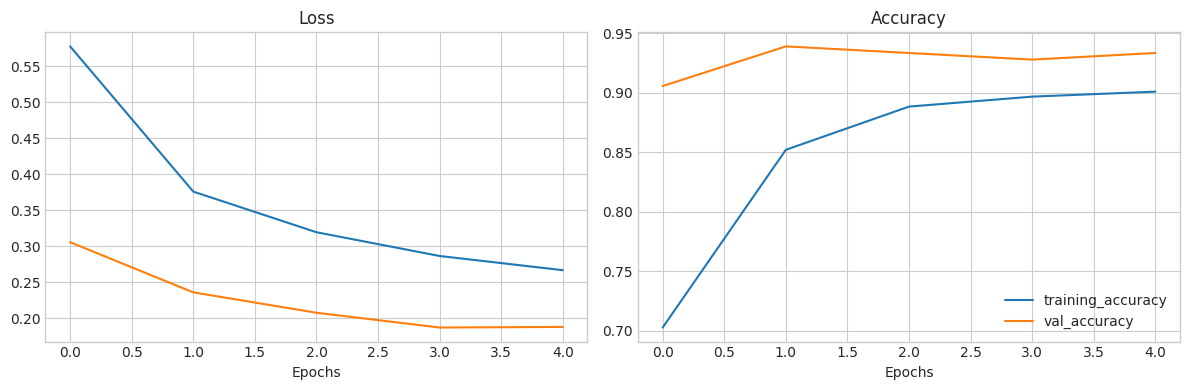

In [20]:
plot_history(base_eff0_history)

In [21]:
base_eff0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 5921874 (22.59 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


#### ⚡️ Data Augmentaion

In [22]:
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_brightness(img, 0.1,seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.5,seed = SEED)
    img = tf.image.random_saturation(img, .5, 1,seed = SEED)
    img = tf.image.random_hue(img, 0.2,seed = SEED)
    return img, label

def loadDatasetWithAugmentaion(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                 .map(augmentation)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE)
           )

In [23]:
# Loading only 25 % for data augmentaion
data_size = len(train_images_df)
train_data_aug_20 = loadDatasetWithAugmentaion(train_images_df.sample(frac=1)[:int(0.25 * data_size)])

Visulize the augmented images

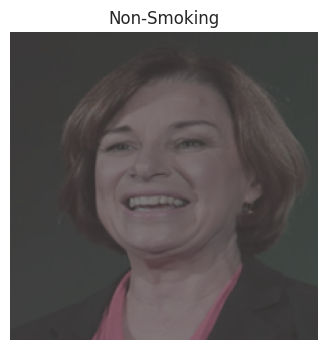

In [24]:
plotRandom(train_data_aug_20)

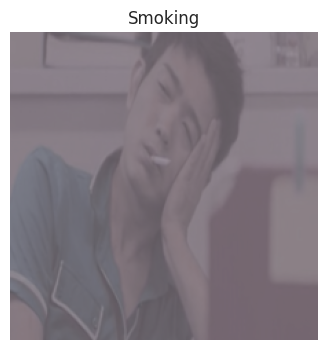

In [25]:
plotRandom(train_data_aug_20)

In [26]:
base_eff_modelOne = create_b0_base()
# compile and fit
base_eff_modelOne.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
base_eff_modelOne_history = base_eff_modelOne.fit(train_data_aug_20,epochs = 5, steps_per_epoch = len(train_data_aug_20),validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5


2023-12-18 18:52:09.686279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 11s 561ms/step - loss: 0.6629 - accuracy: 0.5866 - val_loss: 0.4804 - val_accuracy: 0.8278
Epoch 2/5
6/6 [==============================] - 1s 126ms/step - loss: 0.5266 - accuracy: 0.7542 - val_loss: 0.3868 - val_accuracy: 0.8889
Epoch 3/5
6/6 [==============================] - 1s 132ms/step - loss: 0.4607 - accuracy: 0.7542 - val_loss: 0.3402 - val_accuracy: 0.9000
Epoch 4/5
6/6 [==============================] - 1s 125ms/step - loss: 0.3883 - accuracy: 0.8492 - val_loss: 0.3042 - val_accuracy: 0.9000
Epoch 5/5
6/6 [==============================] - 1s 127ms/step - loss: 0.3486 - accuracy: 0.8547 - val_loss: 0.2750 - val_accuracy: 0.9111


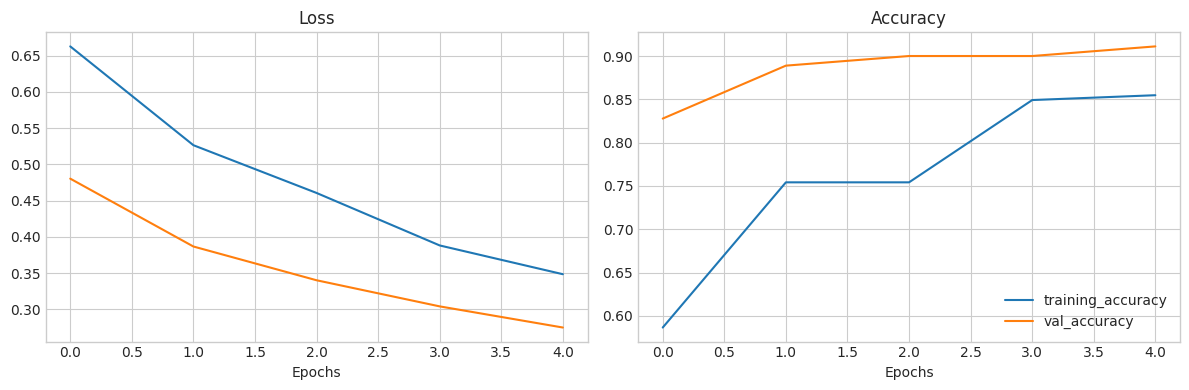

In [27]:
plot_history(base_eff_modelOne_history)